In [2]:
import pathlib
import tensorflow as tf

In [3]:
from tensorflow import keras
from imutils import paths
import cv2

In [4]:
imagePaths = list(paths.list_images("E:\\1. SEMESTER 3\\Project\\Braille Dataset - Copy"))


In [5]:
image_count = len(imagePaths)
image_count

1560

In [6]:
import os
name_list = []
for i in imagePaths:
    name_list.append(os.path.basename(i)[0])

In [7]:
images = []
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    images.append(image)

In [8]:
import numpy as np
images_list = np.array(images)
name_list = np.array(name_list)

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
le = LabelEncoder()
name_list = le.fit_transform(name_list)

In [11]:
# here we have converted the images into a 3D array
images_list = images_list/255.0
print(images_list[0])

[[[0.76078431 0.76078431 0.76078431]
  [0.8        0.8        0.8       ]
  [0.80784314 0.80784314 0.80784314]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 [[0.75686275 0.75686275 0.75686275]
  [0.69411765 0.69411765 0.69411765]
  [0.7372549  0.7372549  0.7372549 ]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 [[0.78039216 0.78039216 0.78039216]
  [0.79607843 0.79607843 0.79607843]
  [0.76470588 0.76470588 0.76470588]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 ...

 [[0.76862745 0.76862745 0.76862745]
  [0.77254902 0.77254902 0.77254902]
  [0.76470588 0.76470588 0.76470588]
  ...
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]
  [0.76862745 0.76862745 0.76862745]]

 [[0.77254902 0.77254902 0.77254902]
  [0.77647059 0.77647059 0.77647059]


In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(images_list, name_list, test_size=0.2, random_state=42)

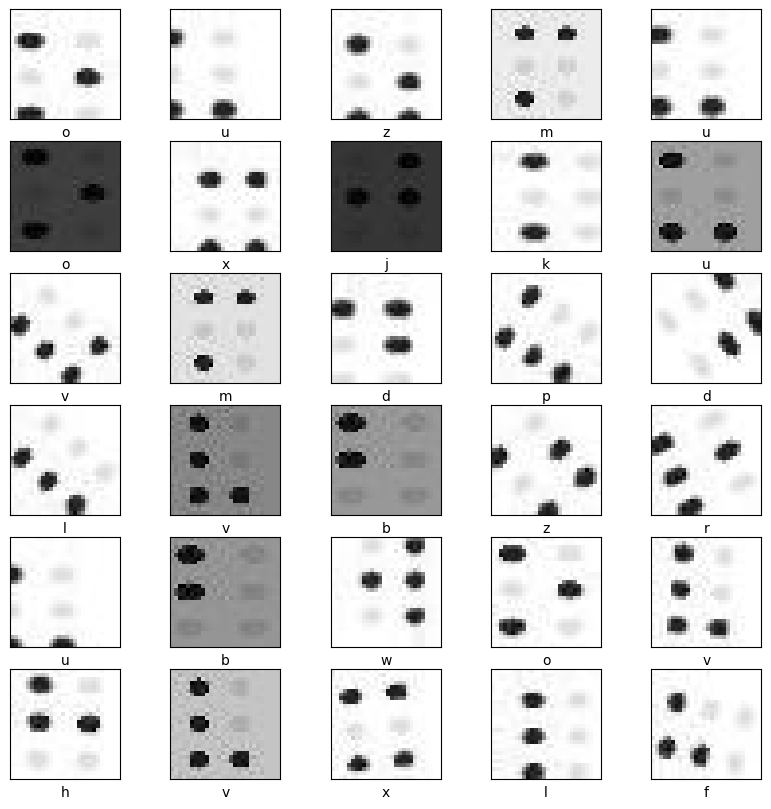

In [14]:
import matplotlib.pyplot as plt
class_names = ['a', 'b', 'c', 'd', 'e', 'f', 'g',
               'h', 'i', 'j', 'k', 'l', 'm', 'n',
               'o', 'p', 'q', 'r', 's', 't', 'u',
               'v', 'w', 'x', 'y', 'z']

plt.figure(figsize=(10,10))
for i in range(30):
    plt.subplot(6,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i])
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [15]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Concatenate, Flatten, Dense, Dropout, Input
from tensorflow.keras.models import Model

def inception_module(x, filters):
    conv1x1 = Conv2D(filters[0], (1, 1), padding='same', activation='relu')(x)

    conv3x3_reduce = Conv2D(filters[1], (1, 1), padding='same', activation='relu')(x)
    conv3x3 = Conv2D(filters[2], (3, 3), padding='same', activation='relu')(conv3x3_reduce)

    conv5x5_reduce = Conv2D(filters[3], (1, 1), padding='same', activation='relu')(x)
    conv5x5 = Conv2D(filters[4], (5, 5), padding='same', activation='relu')(conv5x5_reduce)

    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(x)
    pool_proj = Conv2D(filters[5], (1, 1), padding='same', activation='relu')(pool_proj)

    inception_output = Concatenate(axis=-1)([conv1x1, conv3x3, conv5x5, pool_proj])
    return inception_output

input_shape = (28, 28, 3)  # input images
input_layer = Input(shape=input_shape)

x = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = Conv2D(64, (1, 1), padding='same', activation='relu')(x)
x = Conv2D(192, (3, 3), padding='same', activation='relu')(x)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

x = inception_module(x, [64, 96, 128, 16, 32, 32])
x = inception_module(x, [128, 128, 192, 32, 96, 64])

# Add more inception modules as needed...

x = AveragePooling2D((5, 5), strides=(1, 1), padding='valid')(x)  # Adjust pooling size
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)

num_classes = 26  # Number of Braille characters
output_layer = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)           0         ['conv2d[0][0]']              
 D)                                                                                               
                                                                                                  
 conv2d_1 (Conv2D)           (None, 14, 14, 64)           4160      ['max_pooling2d[0][0]']   

In [16]:
checkpoint_path = "./braille2.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
batch_size = 32

save_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5*batch_size)

In [17]:
model.compile(optimizer="Adam", loss="SparseCategoricalCrossentropy", metrics=["sparse_categorical_accuracy"])

In [18]:
from keras.callbacks import EarlyStopping
es1 = EarlyStopping(patience=20, monitor="val_sparse_categorical_accuracy", mode="auto")
es2 = EarlyStopping(patience=20, monitor="val_loss", mode="auto")


In [19]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=100,
                    validation_split=0.3,
                    callbacks=[es1, es2, save_callback])

Epoch 1/100
28/28 [==============================] - 14s 276ms/step - loss: 3.2661 - sparse_categorical_accuracy: 0.0344 - val_loss: 3.2591 - val_sparse_categorical_accuracy: 0.0320
Epoch 2/100
28/28 [==============================] - 7s 259ms/step - loss: 3.2588 - sparse_categorical_accuracy: 0.0470 - val_loss: 3.2597 - val_sparse_categorical_accuracy: 0.0400
Epoch 3/100
28/28 [==============================] - 7s 253ms/step - loss: 3.2513 - sparse_categorical_accuracy: 0.0527 - val_loss: 3.2335 - val_sparse_categorical_accuracy: 0.0480
Epoch 4/100
28/28 [==============================] - 7s 251ms/step - loss: 3.1317 - sparse_categorical_accuracy: 0.0767 - val_loss: 2.8926 - val_sparse_categorical_accuracy: 0.1280
Epoch 5/100
28/28 [==============================] - 7s 255ms/step - loss: 2.5514 - sparse_categorical_accuracy: 0.2039 - val_loss: 1.8682 - val_sparse_categorical_accuracy: 0.4187
Epoch 6/100
19/28 [===================>..........] - ETA: 2s - loss: 1.9599 - sparse_categoric

28/28 [==============================] - 7s 263ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9874 - val_loss: 0.4705 - val_sparse_categorical_accuracy: 0.8987
Epoch 41/100
28/28 [==============================] - 7s 251ms/step - loss: 0.0198 - sparse_categorical_accuracy: 0.9920 - val_loss: 0.4579 - val_sparse_categorical_accuracy: 0.9093
Epoch 42/100
28/28 [==============================] - 7s 255ms/step - loss: 0.0083 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.3993 - val_sparse_categorical_accuracy: 0.9200
Epoch 43/100
28/28 [==============================] - 7s 254ms/step - loss: 0.0144 - sparse_categorical_accuracy: 0.9954 - val_loss: 0.5475 - val_sparse_categorical_accuracy: 0.9120
Epoch 44/100
28/28 [==============================] - 7s 251ms/step - loss: 0.1564 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.3906 - val_sparse_categorical_accuracy: 0.9013
Epoch 45/100
28/28 [==============================] - 7s 254ms/step - loss: 0.0453 - sparse_categorical

In [20]:
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print("Training Accuracy:", train_accuracy)

39/39 [==============================] - 2s 60ms/step - loss: 0.1574 - sparse_categorical_accuracy: 0.9704
Training Accuracy: 0.9703525900840759


In [21]:
time = np.arange(1, len(history.history['loss'])+1)

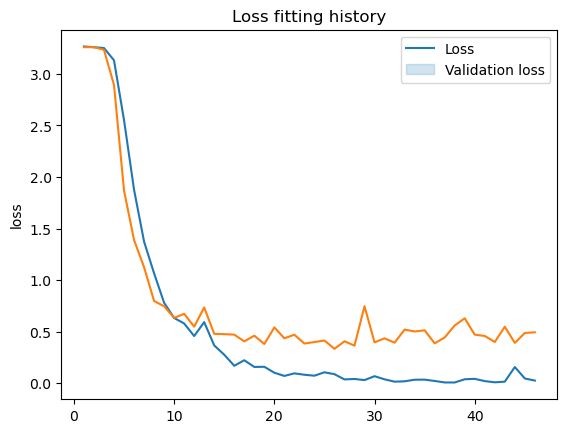

In [22]:
import seaborn as sns
sns.lineplot(data=history.history, x=time, y='loss')
sns.lineplot(data=history.history, x=time, y='val_loss')
plt.title('Loss fitting history')
plt.legend(labels=['Loss', 'Validation loss'])
plt.show()

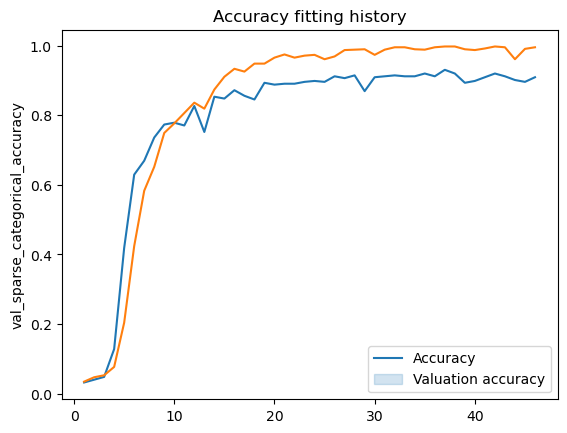

In [23]:
sns.lineplot(data=history.history, x=time, y='val_sparse_categorical_accuracy')
sns.lineplot(data=history.history, x=time, y='sparse_categorical_accuracy')
plt.title('Accuracy fitting history')
plt.legend(labels=['Accuracy', 'Valuation accuracy'])
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(X_test, y_test)

10/10 [==============================] - 1s 60ms/step - loss: 0.3558 - sparse_categorical_accuracy: 0.9423


In [25]:
print('Loss', test_loss)
print('Accuracy', test_acc)

Loss 0.35584649443626404
Accuracy 0.942307710647583


index:  155
1/1 [==============================] - 0s 450ms/step
score:  [[0.00000000e+00 1.02455948e-35 0.00000000e+00 0.00000000e+00
  0.00000000e+00 4.74420486e-28 2.26519546e-38 2.28509688e-30
  0.00000000e+00 0.00000000e+00 0.00000000e+00 5.55424639e-20
  0.00000000e+00 0.00000000e+00 0.00000000e+00 6.21865458e-21
  1.04318505e-22 1.32979660e-16 1.90704034e-32 5.22816987e-28
  1.10960370e-32 1.00000000e+00 1.50430472e-19 0.00000000e+00
  2.47438175e-30 2.13789855e-29]]
Predicted label: v


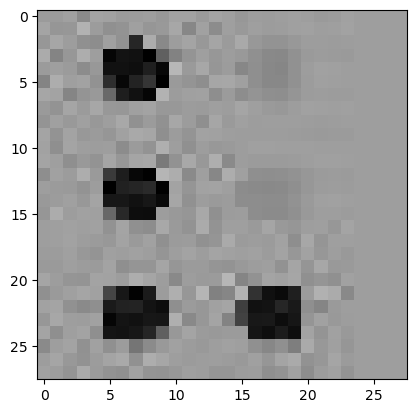

In [26]:
from random import randrange
print("index: ", randrange(312))
index_image = randrange(312)
prediction_scores = model.predict(np.expand_dims(X_test[index_image], axis=0))
predicted_index = np.argmax(prediction_scores)
plt.imshow(X_test[index_image])
print("score: ", prediction_scores)
print("Predicted label: " + class_names[predicted_index])

In [27]:
model.save("BCR1.h5")

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
